# Ensemble Groundwater Predictions (EGP)
*R.A. Collenteur, Eawag, 2024*

In this notebook it is shown how to use Pastas and meteorological ensemble forecasts to generation ensemble groundwater predictions.

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Pastas version: 1.8.0b
Python version: 3.11.9
NumPy version: 1.26.4
Pandas version: 2.2.2
SciPy version: 1.13.1
Matplotlib version: 3.9.0
Numba version: 0.59.1


## Load data

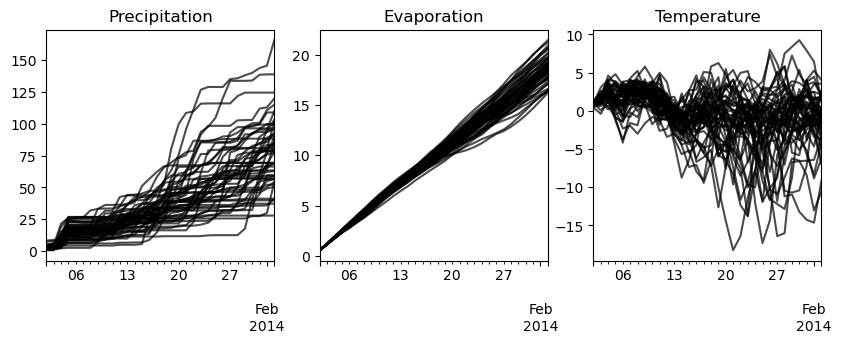

In [2]:
fc = {
    "rch": [
        pd.read_csv("data_forecast/prec.csv", index_col=0, parse_dates=True),
        pd.read_csv("data_forecast/evap.csv", index_col=0, parse_dates=True),
        pd.read_csv("data_forecast/temp.csv", index_col=0, parse_dates=True),
    ]
}

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
names = ["Precipitation", "Evaporation", "Temperature"]
for i in range(3):
    series = fc["rch"][i]
    if i < 2:
        series.cumsum().plot(legend=False, ax=axes[i], color="k", alpha=0.7)
    else:
        series.plot(legend=False, ax=axes[i], color="k", alpha=0.7)

    axes[i].set_title(names[i])

## Make Pastas Model

<Axes: ylabel='Head'>

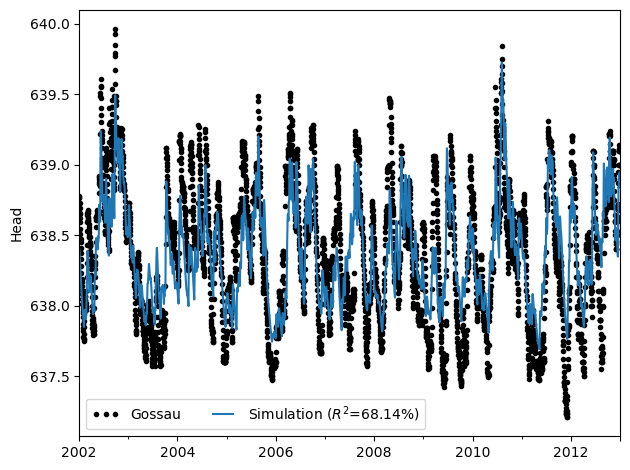

In [3]:
ml = ps.io.load("data_forecast/Gossau.pas")
# ml.solve(noise=False, tmin="2004", tmax="2014")
ml.plot()

## Create predict method

In [4]:
def check_ensemble_data(ens_data):
    n = None
    index = None

    # Check if dataframe
    for smname, smdata in ens_data.items():
        for data in smdata:
            if index is None:
                index = data.index
                n = data.columns.size
            if not data.index.equals(index):
                msg = "ERROR"
                raise Error(msg)
            # check if all are of same size
            if data.columns.size != n:
                msg = "ERROR"
                raise Error(msg)
            data.index.freq = data.index.inferred_freq

    return n, index


def forecast(ml, forecasts, params, post_process=False):
    """Method to forecast the heads from ensembles of stress forecasts.

    Parameters
    ----------

    Returns
    -------

    Notes
    -----


    """
    ml2 = ml.copy()  # Copy the model so old model is unaffected.

    n, index = check_ensemble_data(forecasts)
    tmin = index[0]
    tmax = index[-1]
    nparam = len(params)

    # Create DataFrames to store data
    mi = pd.MultiIndex.from_product(
        [range(n), range(nparam)], names=["meteo_member", "param_member"]
    )
    nopp = pd.DataFrame(index=index, columns=mi, dtype=float)

    if post_process:
        pp = pd.DataFrame(index=index, columns=mi, dtype=float)

    # Generate forecasts with each ensemble member
    for m in range(n):
        # Update stresses with ensemble member data
        for sm_name, fc_data in forecasts.items():
            # Select stressmodel
            sm = ml2.stressmodels[sm_name]

            # Update stress with forecasts
            for i, fc in enumerate(fc_data):
                ts = pd.concat(
                    [
                        sm.stress[i].series_original.loc[: tmin - pd.Timedelta(1, "D")],
                        fc.iloc[:, m],
                    ]
                )
                sm.stress[i].series_original = ts

        # Generate
        raw = np.zeros((index.size, nparam), dtype=float)
        correction = np.zeros((index.size, nparam), dtype=float)

        for j, p in enumerate(params):
            sim = ml2.simulate(p=p, tmin=tmin, tmax=tmax)
            raw[:, j] = sim.values

            if post_process:
                # Post process forecasts
                alpha = p[-1]
                obs = ml2.observations(tmax=tmin)
                last_date = obs.last_valid_index()
                last_residual = obs.loc[last_date] - sim.loc[last_date]
                dt = (index - last_date).days
                correction[:, j] = np.exp(-dt / alpha) * last_residual

        nopp.loc[:, (m, slice(None))] = raw

        if post_process:
            pp.loc[:, (m, slice(None))] = correction

    if post_process:
        pp = pp + nopp
        return nopp, pp
    else:
        return nopp


ml.predict = forecast

## Compute GWL forecasts

<Axes: >

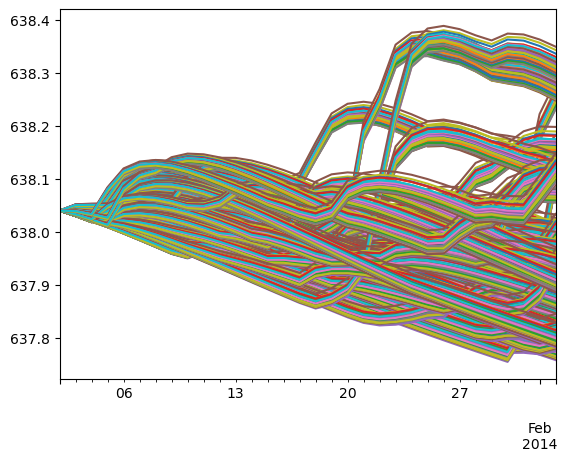

In [5]:
params = ml.solver.get_parameter_sample(n=50)
_, h_fc = ml.predict(ml, fc, params, post_process=True)
h_fc.plot(legend=False)

In [6]:
h_fc

meteo_member          0                                                   \
param_member          0           1           2           3           4    
2014-01-02    638.040000  638.040000  638.040000  638.040000  638.040000   
2014-01-03    638.033448  638.033532  638.033907  638.033611  638.033366   
2014-01-04    638.025647  638.025798  638.026584  638.025950  638.025497   
2014-01-05    638.018776  638.019006  638.020247  638.019255  638.018541   
2014-01-06    638.035995  638.036213  638.038592  638.036856  638.035439   
2014-01-07    638.039774  638.039720  638.042538  638.040435  638.039213   
2014-01-08    638.037543  638.037191  638.040572  638.038028  638.036933   
2014-01-09    638.031632  638.031029  638.035063  638.032012  638.030825   
2014-01-10    638.023313  638.022513  638.027269  638.023633  638.022288   
2014-01-11    638.013379  638.012447  638.017628  638.013707  638.012181   
2014-01-12    638.002347  638.001340  638.007089  638.002751  638.001006   
2014-01-13    638.006784  638.006029  638.012073  638.007538  638.005264   
2014-01-14    638.003926  638.003233  638.009423  638.004684  638.002449   
2014-01-15    637.997702  637.997062  638.003562  637.998507  637.996291   
2014-01-16    637.995254  637.994771  638.001764  637.996364  637.993683   
2014-01-17    637.989130  637.988552  637.996124  637.990181  637.987574   
2014-01-18    637.980895  637.980279  637.988439  637.981949  637.979251   
2014-01-19    637.971301  637.970665  637.979450  637.972415  637.969535   
2014-01-20    637.960812  637.960133  637.969491  637.962013  637.958929   
2014-01-21    637.949596  637.949032  637.958391  637.950977  637.947738   
2014-01-22    637.954014  637.955018  637.963368  637.956381  637.951649   
2014-01-23    637.987789  637.993241  637.998008  637.992549  637.984722   
2014-01-24    638.026724  638.029389  638.037123  638.030075  638.024815   
2014-01-25    638.041981  638.043029  638.051826  638.044174  638.040644   
2014-01-26    638.046517  638.046377  638.056060  638.047871  638.045427   
2014-01-27    638.044774  638.043750  638.054134  638.045536  638.043764   
2014-01-28    638.039068  638.037375  638.048522  638.039434  638.038045   
2014-01-29    638.030761  638.028470  638.040510  638.030876  638.029670   
2014-01-30    638.020392  638.017960  638.029806  638.020386  638.019444   
2014-01-31    638.008105  638.005674  638.017491  638.008072  638.007233   
2014-02-01    637.994697  637.992352  638.004233  637.994723  637.993855   
2014-02-02    637.980501  637.978410  637.990416  637.980729  637.979690   

meteo_member                                                              ...  \
param_member          5           6           7           8           9   ...   
2014-01-02    638.040000  638.040000  638.040000  638.040000  638.040000  ...   
2014-01-03    638.034115  638.033569  638.033583  638.033779  638.033682  ...   
2014-01-04    638.026864  638.025894  638.025859  638.026260  638.026083  ...   
2014-01-05    638.020627  638.019126  638.019060  638.019707  638.019469  ...   
2014-01-06    638.039341  638.035890  638.037102  638.037609  638.037277  ...   
2014-01-07    638.043228  638.039463  638.040983  638.041488  638.040858  ...   
2014-01-08    638.041028  638.037170  638.038635  638.039291  638.038345  ...   
2014-01-09    638.035180  638.031310  638.032536  638.033417  638.032312  ...   
2014-01-10    638.026994  638.023128  638.024011  638.025162  638.024002  ...   
2014-01-11    638.017273  638.013354  638.013871  638.015317  638.014175  ...   
2014-01-12    638.006524  638.002510  638.002647  638.004402  638.003331  ...   
2014-01-13    638.012306  638.006743  638.007727  638.009441  638.008182  ...   
2014-01-14    638.009837  638.003879  638.005070  638.006785  638.005317  ...   
2014-01-15    638.003933  637.997794  637.998925  638.000740  637.999164  ...   
2014-01-16    638.002229  637.995488  637.996561  637.998584  637.996677  ...   
2014-01-17    637.996306  637.989443  

In [7]:
import cProfile

cProfile.run("ml.predict(ml, fc, params, post_process=True)", sort="tottime")

         11242837 function calls (11042875 primitive calls) in 7.197 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2754    1.301    0.000    1.301    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
     2551    0.366    0.000    0.368    0.000 recharge.py:319(get_root_zone_balance)
    16079    0.239    0.000    0.239    0.000 {method 'get_loc' of 'pandas._libs.index.DatetimeEngine' objects}
     2551    0.211    0.000    0.213    0.000 recharge.py:449(get_snow_balance)
2104287/2077382    0.193    0.000    0.339    0.000 {built-in method builtins.isinstance}
     2550    0.119    0.000    0.133    0.000 rfunc.py:368(step)
    46827    0.116    0.000    0.291    0.000 construction.py:519(sanitize_array)
24284/24274    0.099    0.000    0.622    0.000 series.py:371(__init__)
     2562    0.085    0.000    0.085    0.000 {method 'sort' of 'numpy.ndarray' objects}
     5100    0.082    0.000    0.560    0.000 mo

In [16]:
nopp, pp = ps.forecast(ml, fc, 10, post_process=True)

<Axes: >

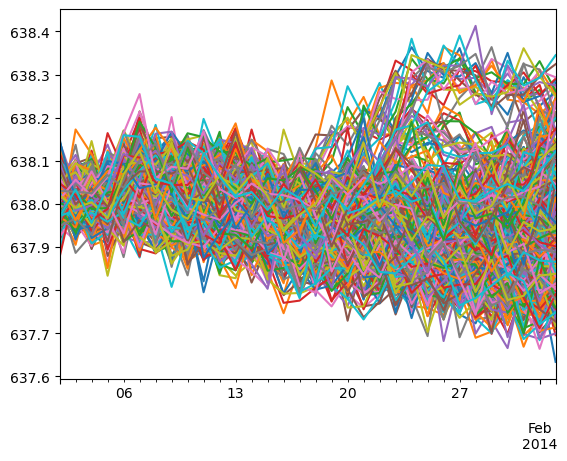

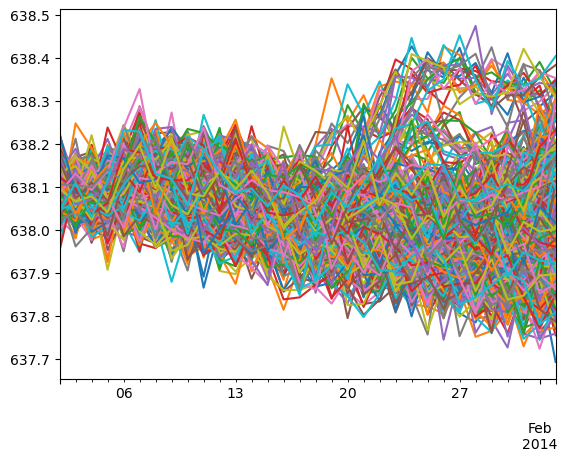

In [17]:
pp.plot(legend=False)
nopp.plot(legend=False)

In [19]:
pp.head()

meteo_member          0                                                   \
param_member           0           1           2           3           4   
2014-01-02    638.127828  637.978948  638.110678  638.092748  638.019322   
2014-01-03    637.937843  637.965730  638.061841  637.956025  638.022751   
2014-01-04    638.020752  637.959415  637.962215  638.060417  638.026586   
2014-01-05    638.023077  637.984178  638.060450  638.082255  637.981909   
2014-01-06    638.024971  638.086518  638.066676  637.990865  638.024732   

meteo_member                                                              ...  \
param_member           5           6           7           8           9  ...   
2014-01-02    638.031772  638.079910  638.030986  637.984758  638.063261  ...   
2014-01-03    638.024438  637.940814  637.991309  638.006060  637.964892  ...   
2014-01-04    637.944890  637.990758  638.057863  638.029571  638.089674  ...   
2014-01-05    638.059320  637.861574  637.985509  638.044002  638.041902  ...   
2014-01-06    638.066509  638.054077  637.999451  638.030364  638.054389  ...   

meteo_member          50                                                  \
param_member           0           1           2           3           4   
2014-01-02    638.146330  638.039885  637.971899  638.047352  638.096360   
2014-01-03    638.009794  637.962489  638.031020  638.021373  637.984095   
2014-01-04    638.017172  638.032360  637.988307  637.962033  637.997150   
2014-01-05    638.099377  638.076058  637.990555  637.988482  638.032928   
2014-01-06    638.093138  638.068542  638.066793  638.112819  638.116352   

meteo_member                                                              
param_member           5           6           7           8           9  
2014-01-02    638.083098  638.010373  638.030267  638.019666  637.970163  
2014-01-03    637.999138  638.056083  638.028239  637.990915  638.033899  
2014-01-04    638.035522  638.018085  638.024734  638.003780  637.956202  
2014-01-05    637.993307  638.063349  638.066787  637.967219  638.041372  
2014-01-06    638.043542  638.163925  638.037659  638.068729  638.159310  

[5 rows x 510 columns]

In [20]:
nopp.head()

meteo_member          0                                                   \
param_member           0           1           2           3           4   
2014-01-02    638.203640  638.054761  638.186491  638.168561  638.095134   
2014-01-03    638.013062  638.040949  638.137061  638.031245  638.097971   
2014-01-04    638.095383  638.034046  638.036845  638.135047  638.101217   
2014-01-05    638.097123  638.058224  638.134496  638.156301  638.055956   
2014-01-06    638.098438  638.159985  638.140142  638.064332  638.098199   

meteo_member                                                              ...  \
param_member           5           6           7           8           9  ...   
2014-01-02    638.107585  638.155723  638.106799  638.060571  638.139074  ...   
2014-01-03    638.099657  638.016033  638.066529  638.081279  638.040111  ...   
2014-01-04    638.019520  638.065389  638.132493  638.104201  638.164304  ...   
2014-01-05    638.133367  637.935620  638.059556  638.118048  638.115948  ...   
2014-01-06    638.139976  638.127544  638.072917  638.103831  638.127855  ...   

meteo_member          50                                                  \
param_member           0           1           2           3           4   
2014-01-02    638.222143  638.115698  638.047712  638.123165  638.172173   
2014-01-03    638.085013  638.037708  638.106239  638.096593  638.059314   
2014-01-04    638.091802  638.106991  638.062938  638.036663  638.071781   
2014-01-05    638.173423  638.150104  638.064601  638.062528  638.106974   
2014-01-06    638.166604  638.142009  638.140260  638.186286  638.189819   

meteo_member                                                              
param_member           5           6           7           8           9  
2014-01-02    638.158911  638.086186  638.106080  638.095479  638.045976  
2014-01-03    638.074358  638.131302  638.103459  638.066134  638.109118  
2014-01-04    638.110152  638.092715  638.099364  638.078410  638.030832  
2014-01-05    638.067353  638.137395  638.140834  638.041265  638.115418  
2014-01-06    638.117009  638.237392  638.111126  638.142195  638.232777  

[5 rows x 510 columns]

<Axes: ylabel='Head'>

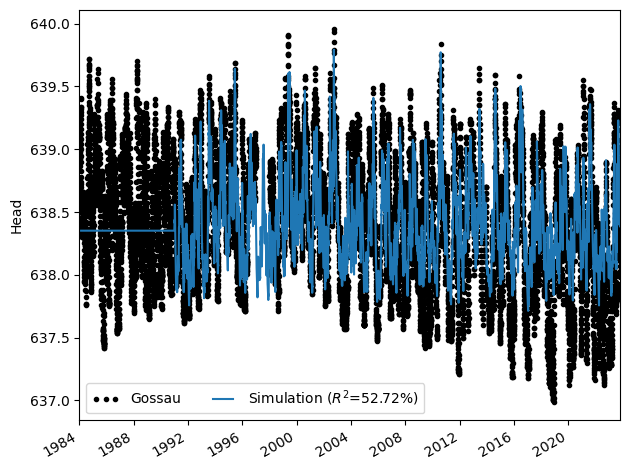

In [13]:
ml.plot()